In [ ]:
!pip install visualkeras pytesseract

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.mkdir('/content/kaggle')

In [ ]:
!unzip /content/drive/MyDrive/FIAP/Deep_Learning/Autoencoders/denoising-dirty-documents.zip -d /content/kaggle/input

Archive:  /content/drive/MyDrive/FIAP/Deep_Learning/Autoencoders/denoising-dirty-documents.zip
  inflating: /content/kaggle/input/sampleSubmission.csv.zip  
  inflating: /content/kaggle/input/test.zip  
  inflating: /content/kaggle/input/train.zip  
  inflating: /content/kaggle/input/train_cleaned.zip  


# Autoencoders Denoise (Denoising Autoencoders):

A ideia principal dos autoencoders denoise é torná-los mais robustos à presença de ruído nos dados de entrada. Em outras palavras, em vez de treinar o autoencoder para reconstruir dados de entrada limpos, você treina o autoencoder para reconstruir dados de entrada que foram deliberadamente corrompidos por algum tipo de ruído.

Aqui está como os autoencoders denoise funcionam:

1. **Adição de Ruído**: Antes de alimentar os dados de entrada no autoencoder, você introduz algum tipo de ruído nos dados. Isso pode ser feito de várias maneiras, como adicionando ruído gaussiano aos pixels de uma imagem ou mascarando aleatoriamente partes do vetor de entrada. O objetivo é simular dados de entrada ruidosos.

2. **Treinamento**: O autoencoder é treinado para reconstruir os dados de entrada corrompidos (com ruído) de volta aos dados de entrada originais. Portanto, ele aprende a remover o ruído e recuperar os dados originais.

3. **Código Latente Robusto**: Durante o treinamento, o autoencoder aprende a representação no código latente que é mais robusta ao ruído. Em outras palavras, o código latente deve conter informações importantes para a reconstrução, independentemente do ruído presente nos dados de entrada.

A principal vantagem dos autoencoders denoise é que eles podem aprender representações mais robustas e significativas dos dados, que são úteis em tarefas de redução de ruído e remoção de artefatos em dados. Eles também têm aplicações em detecção de anomalias, onde podem identificar dados que não se encaixam bem no modelo aprendido.


![1](https://miro.medium.com/v2/resize:fit:5160/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)


### Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

### Preparação dos arquivos no ambiente

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/kaggle/input/train_cleaned.zip
/content/kaggle/input/train.zip
/content/kaggle/input/test.zip
/content/kaggle/input/sampleSubmission.csv.zip


In [ ]:
path_zip = '/content/kaggle/input/'
path = '/content/kaggle/working/'

In [ ]:
for filename in os.listdir(path_zip):
    with zipfile.ZipFile(os.path.join(path_zip, filename), 'r') as zip_ref:
        zip_ref.extractall(path)

In [4]:
train_imgs = sorted(os.listdir(path + '/train'))
train_cleaned_imgs = sorted(os.listdir(path + '/train_cleaned'))
test_imgs = sorted(os.listdir(path + '/test'))

NameError: ignored

### Pré-Processamento

In [ ]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = img/255.0
    img = np.reshape(img, (420, 540, 3))

    return img

In [ ]:
train = []
train_cleaned = []
test = []

for f in train_imgs:
    train.append(process_image(path + 'train/' + f))

for f in train_cleaned_imgs:
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in test_imgs:
    test.append(process_image(path + 'test/' + f))

In [5]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_imgs[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_imgs[i]))

plt.show()

NameError: ignored

### Serapando o dataset

In [ ]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

### Modelo

In [ ]:
def model():
    input_layer = Input(shape=(420, 540, 3))

    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (Batch  (None, 420, 540, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 210, 270, 128)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

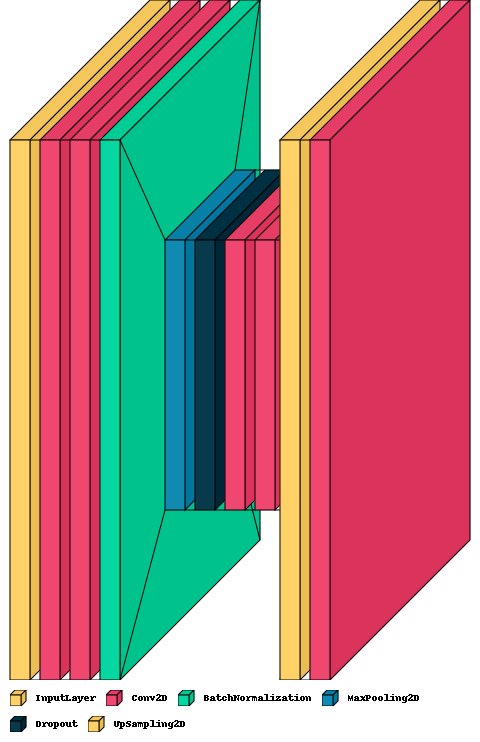

In [ ]:
import visualkeras

visualkeras.layered_view(model, draw_volume=True, scale_xy=1.0,scale_z=0.01, legend=True)

### Treinamento

In [ ]:
callback = EarlyStopping(monitor='loss', patience=8)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=400, batch_size=16, callbacks=[callback])

Epoch 1/400
8/8 [==============================] - 63s 4s/step - loss: 0.1645 - mae: 0.3235 - val_loss: 0.1865 - val_mae: 0.4189
Epoch 2/400
8/8 [==============================] - 12s 1s/step - loss: 0.0802 - mae: 0.2158 - val_loss: 0.1411 - val_mae: 0.3637
Epoch 3/400
8/8 [==============================] - 12s 1s/step - loss: 0.0561 - mae: 0.1755 - val_loss: 0.1036 - val_mae: 0.3060
Epoch 4/400
8/8 [==============================] - 12s 1s/step - loss: 0.0431 - mae: 0.1462 - val_loss: 0.0814 - val_mae: 0.2573
Epoch 5/400
8/8 [==============================] - 12s 1s/step - loss: 0.0352 - mae: 0.1282 - val_loss: 0.0722 - val_mae: 0.2288
Epoch 6/400
8/8 [==============================] - 12s 1s/step - loss: 0.0299 - mae: 0.1147 - val_loss: 0.0674 - val_mae: 0.2020
Epoch 7/400
8/8 [==============================] - 12s 1s/step - loss: 0.0263 - mae: 0.1058 - val_loss: 0.0652 - val_mae: 0.1873
Epoch 8/400
8/8 [==============================] - 12s 1s/step - loss: 0.0231 - mae: 0.0980 - val

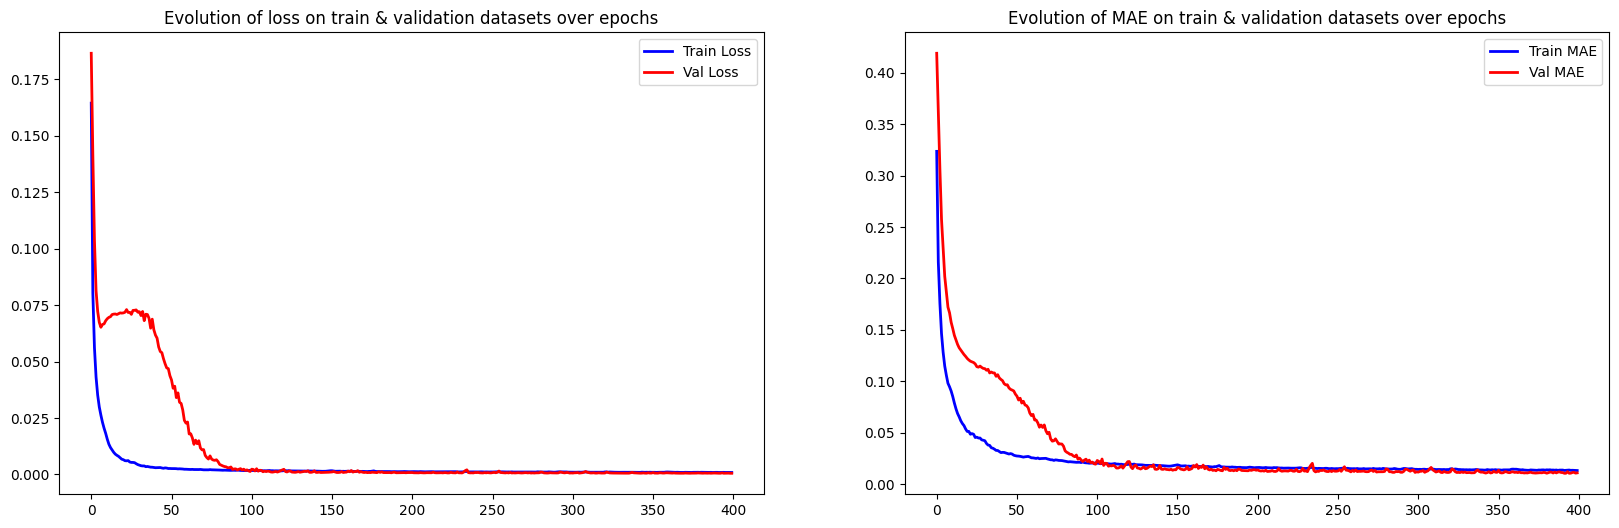

In [ ]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [ ]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

5/5 [==============================] - 6s 1s/step


In [ ]:
plt.figure(figsize=(15,25))
for i in range(0, 8, 2):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i], cmap='gray')
    plt.title('Noisy image: {}'.format(test_imgs[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_imgs[i]))

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.save("denoise_autoencoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


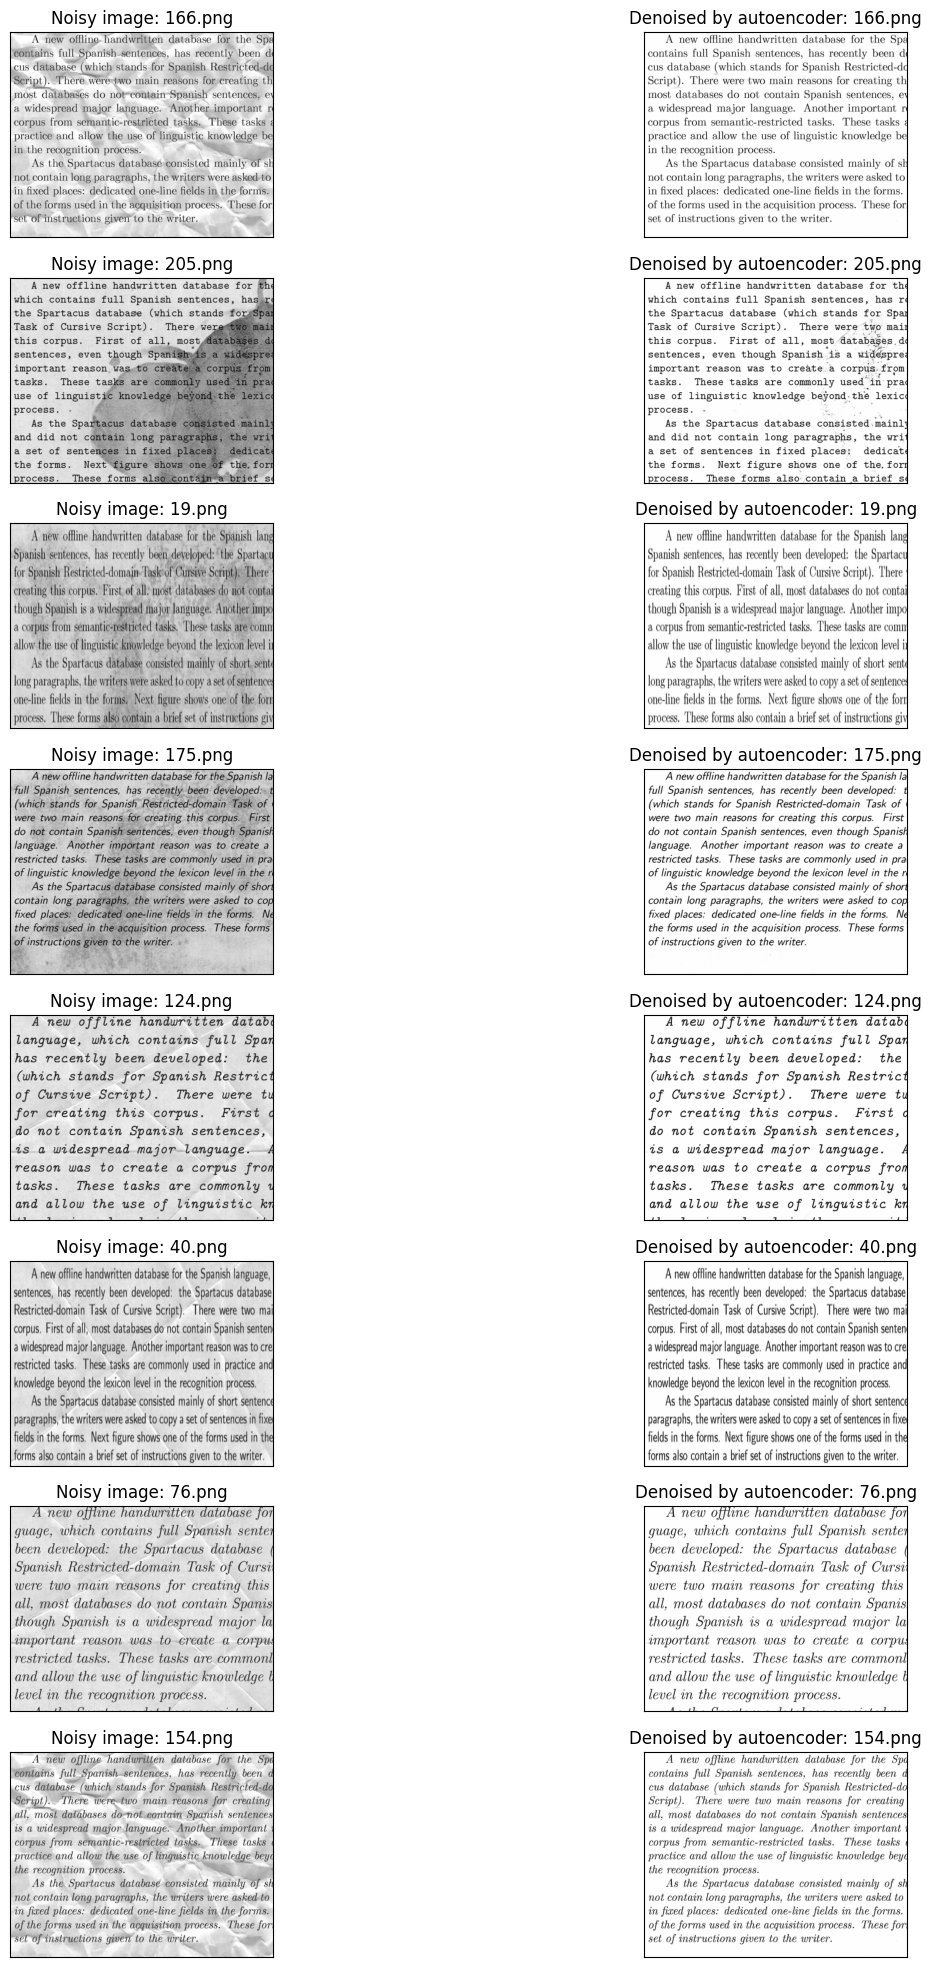

In [ ]:
import random

random_indices = random.sample(range(len(test_imgs)), 8)

plt.figure(figsize=(15, 25))
for i, idx in enumerate(random_indices):
    plt.subplot(8, 2, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[idx], cmap='gray')
    plt.title('Noisy image: {}'.format(test_imgs[idx]))

    plt.subplot(8, 2, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[idx], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_imgs[idx]))

plt.show()
